In [3]:
from IPython.display import display
from IPython.core.display import HTML
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
%matplotlib inline

display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [4]:
import pandas as pd
import numpy as np
import folium
import geojson
import geopandas
import osmnx as ox
import networkx as nx
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from exploration_utils import plot_counter, plot_counters, plot_locations, inspect_diff_area, plot_scatters
from exploration_utils import plot_speed_dayline, plot_flow_dayline, compute_highway_stats

UBER_BASE = Path('/private/data/mets10/validations_ext_uber')
RELEASE_PATH = UBER_BASE / 'release20221028_historic_uber'
COUNTER_PATH = Path('/private/data/mets10/loop_counters')

lat_min, lat_max, lon_min, lon_max = (51.205, 51.7, -0.369, 0.067)

### Load road graph

In [5]:
edges_df = geopandas.read_parquet(RELEASE_PATH / 'road_graph' / 'london' / 'road_graph_edges.parquet')
edges_df

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,19.407060,"LINESTRING (-0.14579 51.52698, -0.14578 51.52680)",Outer Circle
1,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,63.857249,"LINESTRING (-0.14579 51.52698, -0.14581 51.52755)",Outer Circle
2,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,12.645031,"LINESTRING (-0.15279 51.52361, -0.15268 51.52363)",York Gate
3,99936_4544836433_233623258,99936,4544836433,233623258,48.3,30 mph,unclassified,,,,47.220818,"LINESTRING (-0.15279 51.52361, -0.15294 51.523...",York Gate
4,99937_200047_4257261,99937,200047,4257261,48.3,30 mph,unclassified,,,,59.033945,"LINESTRING (-0.15202 51.52302, -0.15232 51.523...",York Gate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6577730921_254761207_358627524,6577730921,254761207,358627524,46.2,,tertiary,,,,134.082828,"LINESTRING (-0.20947 51.52118, -0.20849 51.52188)",Golborne Road
234304,6577730921_6577730928_8227762,6577730921,6577730928,8227762,36.3,,residential,,,,51.325126,"LINESTRING (-0.20947 51.52118, -0.20935 51.521...",Bevington Road
234305,6577730928_2379175_700435511,6577730928,2379175,700435511,36.3,,residential,,,,57.576832,"LINESTRING (-0.20901 51.52114, -0.20906 51.521...",Bevington Road
234306,6577745911_36728211_646234311,6577745911,36728211,646234311,48.3,30 mph,primary,,,,305.243521,"LINESTRING (-0.23975 51.41129, -0.23904 51.411...",Coombe Lane


### Load loop counter locations matched

In [6]:
counters_assigned_df = geopandas.read_parquet(RELEASE_PATH / 'road_graph' / 'london' / 'counters_matched.parquet')
print(len(counters_assigned_df))
counters_assigned_df = counters_assigned_df[counters_assigned_df['way'] != -1]
counters_assigned_df

5917


,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry
0,5,51.575617,0.283162,-1.0,M25/5764B,"[(246241383, 210969437, '246241383_210969437_2...","[1.6568537321059769, 16.015736358032573, 20.85...",22890035,10000000.0,246241383,210969437,POINT (0.28316 51.57562)
1,8,51.433749,-0.538796,-1.0,M25/4876A,"[(1588846837, 1588846655, '1588846837_15888466...","[2.712841032414038, 23.267715270397552]",256060531,10000000.0,1588846837,1588846655,POINT (-0.53880 51.43375)
2,14,51.408466,0.381381,-1.0,A2/8392M,"[(945016995, 260108636, '945016995_260108636_4...",[30.615473857873027],42400295,10000000.0,945016995,260108636,POINT (0.38138 51.40847)
3,24,51.520645,-2.049237,-1.0,M4/3479A,[],[],-1,-1.0,-1,-1,POINT (-2.04924 51.52064)
4,25,51.664773,-0.493692,-1.0,M25/5135B,"[(1776487329, 13353263, '1776487329_13353263_4...","[2.137603239380767, 17.36775801843935]",4208528,10000000.0,1776487329,13353263,POINT (-0.49369 51.66477)
...,...,...,...,...,...,...,...,...,...,...,...,...
5912,32/210,51.612580,-0.113407,-1.0,,"[(4065358677, 196424, '4065358677_196424_40426...","[1.5074836979383113, 10.46175080563993, 21.934...",404260442,10000000.0,4065358677,196424,POINT (-0.11341 51.61258)
5913,32/224,51.632029,-0.073554,-1.0,,"[(1439294240, 497161, '1439294240_497161_81220...","[1.8084786013917726, 11.618542945204045]",8122037,10000000.0,1439294240,497161,POINT (-0.07355 51.63203)
5914,32/225,51.631973,-0.073398,-1.0,,"[(4297211162, 1052641793, '4297211162_10526417...","[1.406376688201597, 13.290152730149995]",1656423,10000000.0,4297211162,1052641793,POINT (-0.07340 51.63197)
5915,32/228,51.629826,-0.097257,-1.0,,"[(256632553, 26026556, '256632553_26026556_812...","[1.5865900035410672, 1.5865900035410672, 1.586...",8122359,10000000.0,256632553,26026556,POINT (-0.09726 51.62983)


In [6]:
compute_highway_stats(counters_assigned_df, edges_df)

,count,share,share_full
highway,,,
motorway,1214,25 %,25.296937
primary,1530,32 %,31.881642
residential,157,3 %,3.271515
secondary,259,5 %,5.396958
service,2,0 %,0.041675
tertiary,347,7 %,7.230673
trunk,1214,25 %,25.296937
unclassified,76,2 %,1.583663


In [7]:
counters_assigned_df = counters_assigned_df[(counters_assigned_df['way'] != -1) & (counters_assigned_df['way'] != '-1')]
counters_assigned_df

,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry
0,5,51.575617,0.283162,-1.0,M25/5764B,"[(246241383, 210969437, '246241383_210969437_2...","[1.6568537321059769, 16.015736358032573, 20.85...",22890035,10000000.0,246241383,210969437,POINT (0.28316 51.57562)
1,8,51.433749,-0.538796,-1.0,M25/4876A,"[(1588846837, 1588846655, '1588846837_15888466...","[2.712841032414038, 23.267715270397552]",256060531,10000000.0,1588846837,1588846655,POINT (-0.53880 51.43375)
2,14,51.408466,0.381381,-1.0,A2/8392M,"[(945016995, 260108636, '945016995_260108636_4...",[30.615473857873027],42400295,10000000.0,945016995,260108636,POINT (0.38138 51.40847)
4,25,51.664773,-0.493692,-1.0,M25/5135B,"[(1776487329, 13353263, '1776487329_13353263_4...","[2.137603239380767, 17.36775801843935]",4208528,10000000.0,1776487329,13353263,POINT (-0.49369 51.66477)
5,28,51.268629,-0.166750,-1.0,M25/4490B,"[(1639045045, 202952, '1639045045_202952_23189...","[1.0402302020833283, 22.314515722000312, 29.15...",23189325,10000000.0,1639045045,202952,POINT (-0.16675 51.26863)
...,...,...,...,...,...,...,...,...,...,...,...,...
5912,32/210,51.612580,-0.113407,-1.0,,"[(4065358677, 196424, '4065358677_196424_40426...","[1.5074836979383113, 10.46175080563993, 21.934...",404260442,10000000.0,4065358677,196424,POINT (-0.11341 51.61258)
5913,32/224,51.632029,-0.073554,-1.0,,"[(1439294240, 497161, '1439294240_497161_81220...","[1.8084786013917726, 11.618542945204045]",8122037,10000000.0,1439294240,497161,POINT (-0.07355 51.63203)
5914,32/225,51.631973,-0.073398,-1.0,,"[(4297211162, 1052641793, '4297211162_10526417...","[1.406376688201597, 13.290152730149995]",1656423,10000000.0,4297211162,1052641793,POINT (-0.07340 51.63197)
5915,32/228,51.629826,-0.097257,-1.0,,"[(256632553, 26026556, '256632553_26026556_812...","[1.5865900035410672, 1.5865900035410672, 1.586...",8122359,10000000.0,256632553,26026556,POINT (-0.09726 51.62983)


In [8]:
def way_ambiguity(ways, way_dists):
    way_dists = eval(way_dists)
    if len(way_dists) < 2:
#         print(f'{ways}: {way_dists}')
        return 10
    p = 0
    if way_dists[0] == way_dists[1] and len(way_dists) > 2:
        p = 1  # TODO use check for oneway here
    amb = (way_dists[p+1] - way_dists[p])
    if amb == 0:
        return 0
    amb =  way_dists[p] / amb
    if amb > 10:
        amb = 10
    return amb


counters_assigned_df['way_ambiguity'] = [way_ambiguity(w, wd) for w, wd in
    zip(counters_assigned_df['ways'], counters_assigned_df['way_dists'])]
counters_assigned_df

/usr/local/Caskroom/miniconda/base/envs/t4c22/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry,way_ambiguity
0,5,51.575617,0.283162,-1.0,M25/5764B,"[(246241383, 210969437, '246241383_210969437_2...","[1.6568537321059769, 16.015736358032573, 20.85...",22890035,10000000.0,246241383,210969437,POINT (0.28316 51.57562),0.115389
1,8,51.433749,-0.538796,-1.0,M25/4876A,"[(1588846837, 1588846655, '1588846837_15888466...","[2.712841032414038, 23.267715270397552]",256060531,10000000.0,1588846837,1588846655,POINT (-0.53880 51.43375),0.131980
2,14,51.408466,0.381381,-1.0,A2/8392M,"[(945016995, 260108636, '945016995_260108636_4...",[30.615473857873027],42400295,10000000.0,945016995,260108636,POINT (0.38138 51.40847),10.000000
4,25,51.664773,-0.493692,-1.0,M25/5135B,"[(1776487329, 13353263, '1776487329_13353263_4...","[2.137603239380767, 17.36775801843935]",4208528,10000000.0,1776487329,13353263,POINT (-0.49369 51.66477),0.140353
5,28,51.268629,-0.166750,-1.0,M25/4490B,"[(1639045045, 202952, '1639045045_202952_23189...","[1.0402302020833283, 22.314515722000312, 29.15...",23189325,10000000.0,1639045045,202952,POINT (-0.16675 51.26863),0.048896
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5912,32/210,51.612580,-0.113407,-1.0,,"[(4065358677, 196424, '4065358677_196424_40426...","[1.5074836979383113, 10.46175080563993, 21.934...",404260442,10000000.0,4065358677,196424,POINT (-0.11341 51.61258),0.168354
5913,32/224,51.632029,-0.073554,-1.0,,"[(1439294240, 497161, '1439294240_497161_81220...","[1.8084786013917726, 11.618542945204045]",8122037,10000000.0,1439294240,497161,POINT (-0.07355 51.63203),0.184349
5914,32/225,51.631973,-0.073398,-1.0,,"[(4297211162, 1052641793, '4297211162_10526417...","[1.406376688201597, 13.290152730149995]",1656423,10000000.0,4297211162,1052641793,POINT (-0.07340 51.63197),0.118344
5915,32/228,51.629826,-0.097257,-1.0,,"[(256632553, 26026556, '256632553_26026556_812...","[1.5865900035410672, 1.5865900035410672, 1.586...",8122359,10000000.0,256632553,26026556,POINT (-0.09726 51.62983),0.000000


<AxesSubplot: >

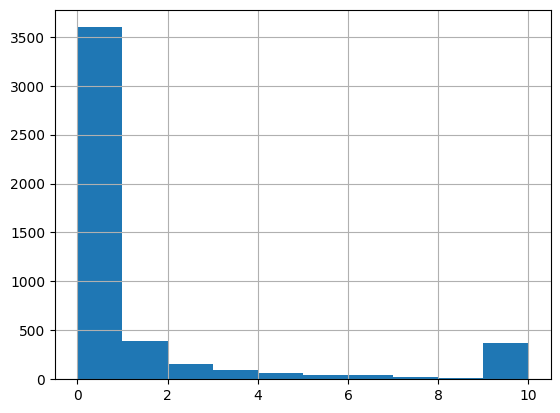

In [9]:
counters_assigned_df['way_ambiguity'].hist()

### Load loop counter speed values (WEBTRIS)

In [7]:
counter_speed_df = pd.read_parquet(COUNTER_PATH / 'london' / 'speed' / 'webtris_london_201907-202001.parquet')
counter_speed_df = counter_speed_df[
        (counter_speed_df['lat'] >= lat_min) & (counter_speed_df['lat'] <= lat_max) &
        (counter_speed_df['lon'] >= lon_min) & (counter_speed_df['lon'] <= lon_max)]
all_webtris_df = counter_speed_df
counter_speed_df

,id,name,lat,lon,heading,time_bin,volume,speed_counter,t,day
20832,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 00:15,0,0.00000,0,2019-07-01
20833,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 00:30,0,0.00000,1,2019-07-01
20834,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 00:45,0,0.00000,2,2019-07-01
20835,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 01:00,0,0.00000,3,2019-07-01
20836,57,M25/4322B,51.273244,0.063816,-1,2019-07-01 01:15,0,0.00000,4,2019-07-01
...,...,...,...,...,...,...,...,...,...,...
38683,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:00,347,106.21644,91,2020-01-31
38684,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:15,274,106.21644,92,2020-01-31
38685,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:30,184,102.99776,93,2020-01-31
38686,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:45,193,104.60710,94,2020-01-31


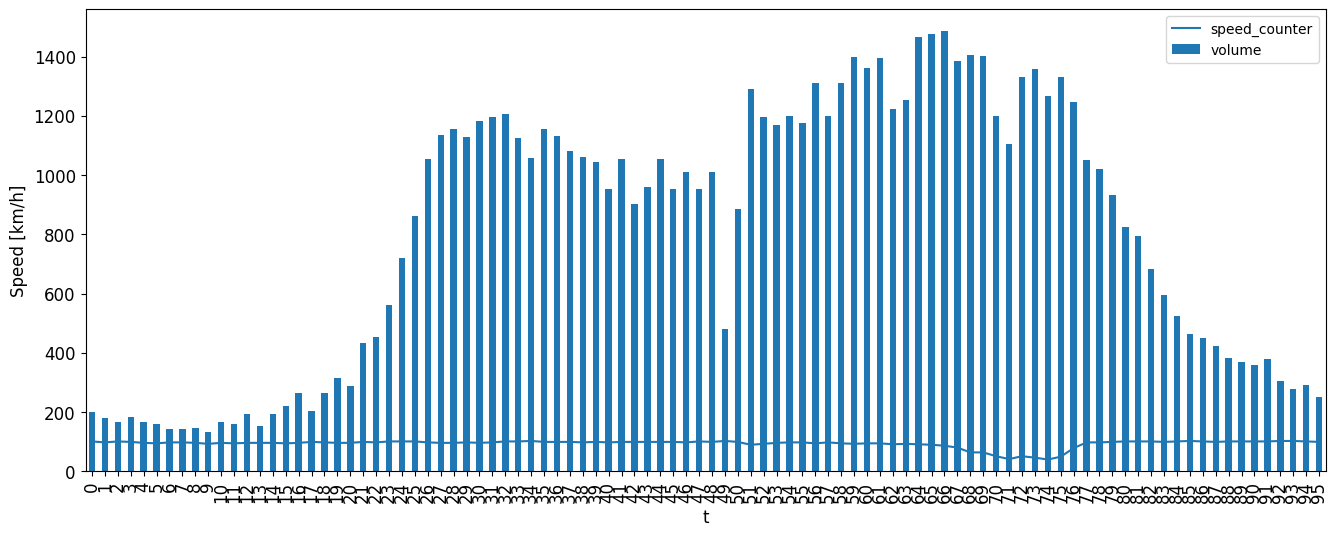

In [11]:
plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2020-01-22')], '6137', plot_volume=True)
plot_counter(counters_assigned_df, edges_df, '6137')

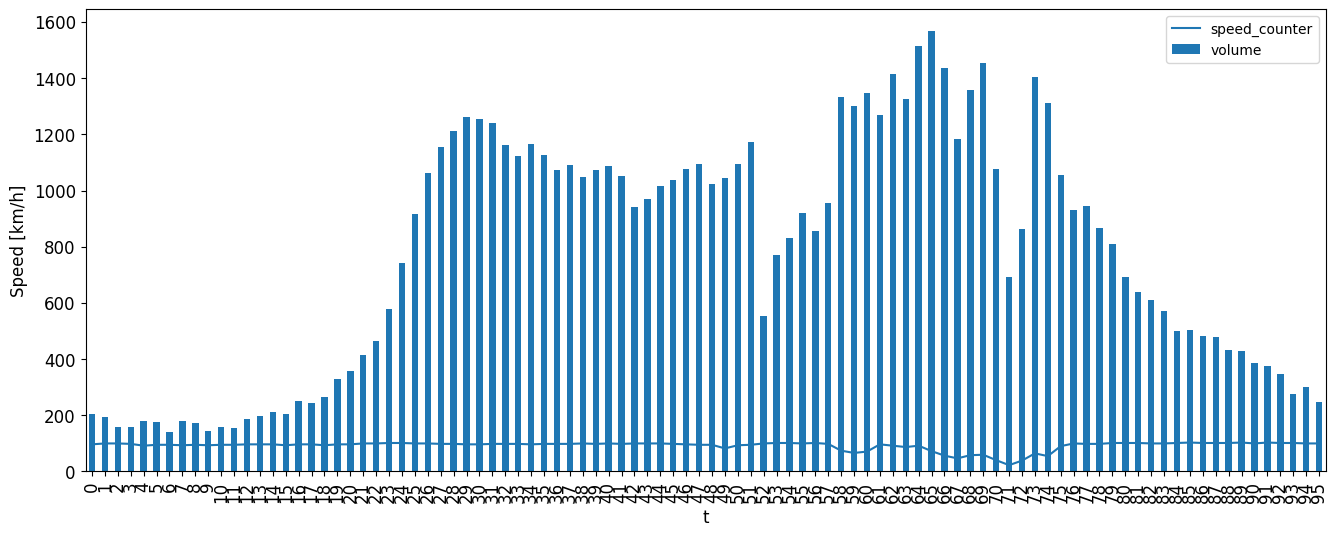

In [12]:
plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2020-01-29')], '6137', plot_volume=True)
plot_counter(counters_assigned_df, edges_df, '6137')

In [53]:
# plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2019-01-01')], '6137', plot_volume=True)
# plot_counter(counters_assigned_df, edges_df, '6137')

In [ ]:
# plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2019-07-04')], '6137', plot_volume=True)
# plot_counter(counters_assigned_df, edges_df, '6137')

In [54]:
# plot_speed_dayline(all_webtris_df[(all_webtris_df['day'] == '2020-01-29')], '1737', plot_volume=True)
# plot_counter(counters_assigned_df, edges_df, '1737')

In [11]:
# Select a single day and merge with the locations
counter_speeds_oneday = counter_speed_df[counter_speed_df['day'] == '2020-01-29'].merge(
    counters_assigned_df[['id', 'way', 'u', 'v']], on=['id'])
counter_speeds_oneday

,id,name,lat,lon,heading,time_bin,volume,speed_counter,t,day,way,u,v
0,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 00:15,0,0.00000,0,2020-01-29,-1,-1,-1
1,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 00:30,0,0.00000,1,2020-01-29,-1,-1,-1
2,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 00:45,0,0.00000,2,2020-01-29,-1,-1,-1
3,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 01:00,0,0.00000,3,2020-01-29,-1,-1,-1
4,57,M25/4322B,51.273244,0.063816,-1,2020-01-29 01:15,0,0.00000,4,2020-01-29,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38585,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:00,164,109.43512,91,2020-01-29,4546652,27461215,197771
38586,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:15,128,107.82578,92,2020-01-29,4546652,27461215,197771
38587,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:30,123,106.21644,93,2020-01-29,4546652,27461215,197771
38588,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:45,134,102.99776,94,2020-01-29,4546652,27461215,197771


In [12]:
def is_valid_counter(s):
    h = np.histogram(s, bins=2)
    return h[-1][-1]

invalid_counters = counter_speeds_oneday[['id', 'speed_counter']].groupby(by=['id']).agg(list).reset_index()
invalid_counters['shist'] = [is_valid_counter(s) for s in invalid_counters['speed_counter']]
invalid_counters = invalid_counters[invalid_counters['shist'] < 1]
invalid_counters

,id,speed_counter,shist
1,10071,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
3,10258,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
4,10271,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
6,10286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
9,10324,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
...,...,...,...
381,963,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
382,9631,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
388,9762,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5
394,981,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5


In [15]:
counter_speeds_oneday = counter_speeds_oneday[~counter_speeds_oneday['id'].isin(invalid_counters['id'])]
counter_speeds_oneday

,id,name,lat,lon,heading,time_bin,volume,speed_counter,t,day,way,u,v
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,2714200,12079091,202953
1,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,2714200,12079091,202953
2,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:45,69,98.16974,2,2020-01-29,2714200,12079091,202953
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 01:00,72,99.77908,3,2020-01-29,2714200,12079091,202953
4,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 01:15,53,93.34172,4,2020-01-29,2714200,12079091,202953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33305,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:00,164,109.43512,91,2020-01-29,4546652,27461215,197771
33306,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:15,128,107.82578,92,2020-01-29,4546652,27461215,197771
33307,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:30,123,106.21644,93,2020-01-29,4546652,27461215,197771
33308,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 23:45,134,102.99776,94,2020-01-29,4546652,27461215,197771


In [18]:
counter_speeds_onemonth = counter_speed_df[counter_speed_df['day'].str.startswith('2020-01')].merge(
    counters_assigned_df[['id', 'way', 'u', 'v']], on=['id'])
counter_speeds_onemonth = counter_speeds_onemonth[~counter_speeds_onemonth['id'].isin(invalid_counters['id'])]
counter_speeds_onemonth['h'] = (counter_speeds_onemonth['t'] / 4).astype(int)
counter_speeds_onemonth

,id,name,lat,lon,heading,time_bin,volume,speed_counter,t,day,way,u,v,h
2976,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,2714200,12079091,202953,0
2977,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:30,52,101.38842,1,2020-01-01,2714200,12079091,202953,0
2978,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:45,62,101.38842,2,2020-01-01,2714200,12079091,202953,0
2979,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 01:00,72,94.95106,3,2020-01-01,2714200,12079091,202953,0
2980,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 01:15,107,109.43512,4,2020-01-01,2714200,12079091,202953,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196347,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:00,347,106.21644,91,2020-01-31,4546652,27461215,197771,22
1196348,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:15,274,106.21644,92,2020-01-31,4546652,27461215,197771,23
1196349,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:30,184,102.99776,93,2020-01-31,4546652,27461215,197771,23
1196350,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:45,193,104.60710,94,2020-01-31,4546652,27461215,197771,23


### Load T4c speed values

In [14]:
speed_files = sorted(list((RELEASE_PATH / 'speed_classes' / 'london').glob('*.parquet')))
speed_files[-3:]

[PosixPath('/private/data/mets10/validations_ext_uber/release20221028_historic_uber/speed_classes/london/speed_classes_2020-01-29.parquet'),
 PosixPath('/private/data/mets10/validations_ext_uber/release20221028_historic_uber/speed_classes/london/speed_classes_2020-01-30.parquet'),
 PosixPath('/private/data/mets10/validations_ext_uber/release20221028_historic_uber/speed_classes/london/speed_classes_2020-01-31.parquet')]

In [17]:
speed_df = pd.read_parquet(RELEASE_PATH / 'speed_classes' / 'london' / 'speed_classes_2020-01-29.parquet')
speed_df = speed_df.rename(columns={'median_speed_kph': 'speed_probes'})
speed_df

,u,v,gkey,osmid,day,t,volume_class,volume,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph
0,78112,25508583,78112_25508583_129375498,129375498,2020-01-29,3,5,7.0,32.941176,28.862745,11.509921,45.176471
1,78112,25508583,78112_25508583_129375498,129375498,2020-01-29,19,3,4.0,19.294118,19.294118,5.647059,45.176471
2,78112,25508583,78112_25508583_129375498,129375498,2020-01-29,29,5,5.0,42.823529,42.509804,1.173853,45.176471
3,78112,25508583,78112_25508583_129375498,129375498,2020-01-29,31,1,1.0,42.823529,42.823529,0.000000,45.176471
4,78112,25508583,78112_25508583_129375498,129375498,2020-01-29,34,3,4.0,38.588235,37.333333,3.943468,45.176471
...,...,...,...,...,...,...,...,...,...,...,...,...
4109245,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-29,70,3,3.0,48.352941,48.352941,7.647059,47.294118
4109246,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-29,73,3,3.0,44.470588,44.470588,1.647059,47.294118
4109247,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-29,78,5,6.0,39.647059,39.647059,0.588235,47.294118
4109248,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-29,80,3,3.0,56.352941,56.352941,0.588235,47.294118


In [15]:
def read_speed_month():
    speed_dfs = []
    speed_files = sorted(list((RELEASE_PATH / 'speed_classes' / 'london').glob('*2020-01*.parquet')))
    for sf in speed_files:
        speed_df = pd.read_parquet(sf)
        speed_df = speed_df.rename(columns={'median_speed_kph': 'speed_probes'})
        speed_df['h'] = (speed_df['t'] / 4).astype(int)
        speed_df = speed_df[['u', 'v', 'gkey', 'osmid', 'day', 'h', 'volume', 'speed_probes']]
        print(len(speed_df))
        speed_dfs.append(speed_df)
    return pd.concat(speed_dfs)

speed_df_onemonth = read_speed_month()
speed_df_onemonth

1519655
3381895
3556268
2949222
2547568
3963000
4048094
4082485
4055971
4087896
3251623
2606571
3997438
4127239
4109250
4106339
4068437


,u,v,gkey,osmid,day,h,volume,speed_probes
0,78112,25508583,78112_25508583_129375498,129375498,2020-01-01,0,5.0,39.529412
1,78112,25508583,78112_25508583_129375498,129375498,2020-01-01,9,1.0,53.647059
2,78112,25508583,78112_25508583_129375498,129375498,2020-01-01,16,3.0,23.058824
3,78112,25508584,78112_25508584_129375498,129375498,2020-01-01,10,3.0,19.529412
4,78112,25508584,78112_25508584_129375498,129375498,2020-01-01,13,3.0,17.411765
...,...,...,...,...,...,...,...,...
4068432,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-31,19,4.0,45.647059
4068433,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-31,19,2.0,56.235294
4068434,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-31,20,3.0,41.647059
4068435,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-31,21,1.0,49.882353


In [16]:
speed_hour_df_onemonth = speed_df_onemonth.groupby(by=['u', 'v', 'gkey', 'osmid', 'day', 'h']).mean().reset_index()
speed_hour_df_onemonth

,u,v,gkey,osmid,day,h,volume,speed_probes
0,78112,25508583,78112_25508583_129375498,129375498,2020-01-01,0,5.0,39.529412
1,78112,25508583,78112_25508583_129375498,129375498,2020-01-01,9,1.0,53.647059
2,78112,25508583,78112_25508583_129375498,129375498,2020-01-01,16,3.0,23.058824
3,78112,25508583,78112_25508583_129375498,129375498,2020-01-02,6,2.0,31.882353
4,78112,25508583,78112_25508583_129375498,129375498,2020-01-02,7,6.0,33.411765
...,...,...,...,...,...,...,...,...
29997480,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-31,18,4.0,44.117647
29997481,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-31,19,3.0,50.941176
29997482,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-31,20,3.0,41.647059
29997483,6577745911,5930672687,6577745911_5930672687_646234311,646234311,2020-01-31,21,1.0,49.882353


# Compare Speed Values

In [80]:
speeds_merged = counter_speeds_oneday.merge(speed_df, on=['u', 'v', 't'])
speeds_merged

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day_x,...,v,gkey,osmid,day_y,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,...,202953,12079091_202953_2714200,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235
1,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:15,82,102.99776,0,2020-01-29,...,202953,12079091_202953_2714200,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235
2,4719,M25/4470A,51.264807,-0.138836,-1,2020-01-29 00:15,88,88.51370,0,2020-01-29,...,202953,12079091_202953_2714200,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,...,202953,12079091_202953_2714200,2714200,2020-01-29,5,13.0,89.882353,71.905882,37.783166,110.588235
4,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:30,74,99.77908,1,2020-01-29,...,202953,12079091_202953_2714200,2714200,2020-01-29,5,13.0,89.882353,71.905882,37.783166,110.588235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19783,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 21:45,408,106.21644,86,2020-01-29,...,197771,27461215_197771_4546652,4546652,2020-01-29,5,8.0,114.941176,114.941176,0.823529,111.058824
19784,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:00,338,106.21644,87,2020-01-29,...,197771,27461215_197771_4546652,4546652,2020-01-29,5,16.0,110.196078,109.712418,5.526753,111.058824
19785,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:15,347,107.82578,88,2020-01-29,...,197771,27461215_197771_4546652,4546652,2020-01-29,5,7.0,98.823529,101.552941,5.962930,111.058824
19786,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:30,310,107.82578,89,2020-01-29,...,197771,27461215_197771_4546652,4546652,2020-01-29,5,6.0,117.176471,112.862745,10.214463,111.058824


In [81]:
speeds_merged = speeds_merged[speeds_merged['volume_y'] > 0]
speeds_merged['diff'] = (speeds_merged['speed_counter'] - speeds_merged['speed_probes']).abs()
speeds_merged

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day_x,...,gkey,osmid,day_y,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph,diff
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,...,12079091_202953_2714200,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235,6.085321
1,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:15,82,102.99776,0,2020-01-29,...,12079091_202953_2714200,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235,17.350701
2,4719,M25/4470A,51.264807,-0.138836,-1,2020-01-29 00:15,88,88.51370,0,2020-01-29,...,12079091_202953_2714200,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235,2.866641
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,...,12079091_202953_2714200,2714200,2020-01-29,5,13.0,89.882353,71.905882,37.783166,110.588235,6.678047
4,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:30,74,99.77908,1,2020-01-29,...,12079091_202953_2714200,2714200,2020-01-29,5,13.0,89.882353,71.905882,37.783166,110.588235,9.896727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19783,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 21:45,408,106.21644,86,2020-01-29,...,27461215_197771_4546652,4546652,2020-01-29,5,8.0,114.941176,114.941176,0.823529,111.058824,8.724736
19784,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:00,338,106.21644,87,2020-01-29,...,27461215_197771_4546652,4546652,2020-01-29,5,16.0,110.196078,109.712418,5.526753,111.058824,3.979638
19785,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:15,347,107.82578,88,2020-01-29,...,27461215_197771_4546652,4546652,2020-01-29,5,7.0,98.823529,101.552941,5.962930,111.058824,9.002251
19786,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:30,310,107.82578,89,2020-01-29,...,27461215_197771_4546652,4546652,2020-01-29,5,6.0,117.176471,112.862745,10.214463,111.058824,9.350691


In [82]:
len(speeds_merged['id'].unique())

221

In [83]:
counters_speed_df = speeds_merged[['id', 'u', 'v', 'way']].groupby(by=['id', 'u', 'v', 'way']).count().reset_index()
counters_speed_df['way'] = counters_speed_df['way'].astype(str)
counters_stats_df = counters_speed_df.merge(edges_df, left_on=['u', 'v', 'way'], right_on=['u', 'v', 'osmid'])
counters_stats_df = counters_stats_df[['id', 'highway']]
counters_stats_df['hwc'] = counters_stats_df['highway'].str.replace('_link', '')
counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*trunk.*', 'trunk')
counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*primary.*', 'primary')
highway_stats = counters_stats_df[['hwc', 'highway']].groupby(by=['hwc']).count().reset_index()
highway_stats = highway_stats.rename(columns={'highway': 'count'})
highway_stats = highway_stats.rename(columns={'hwc': 'highway'})
highway_stats['share'] = (highway_stats['count'] / len(counters_stats_df) * 100).round()
highway_stats = highway_stats.set_index('highway')
highway_stats.style.format({'share': "{:.0f} %"})

/var/folders/dr/jy4_0c5d3q37snprz6rhwwt40000gn/T/ipykernel_57243/2805691077.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*trunk.*', 'trunk')
/var/folders/dr/jy4_0c5d3q37snprz6rhwwt40000gn/T/ipykernel_57243/2805691077.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*primary.*', 'primary')


,count,share
highway,,
motorway,210,95 %
trunk,11,5 %


<AxesSubplot: >

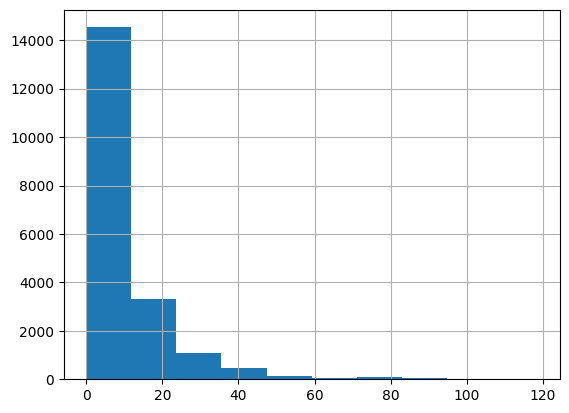

In [84]:
speeds_merged['diff'].hist()

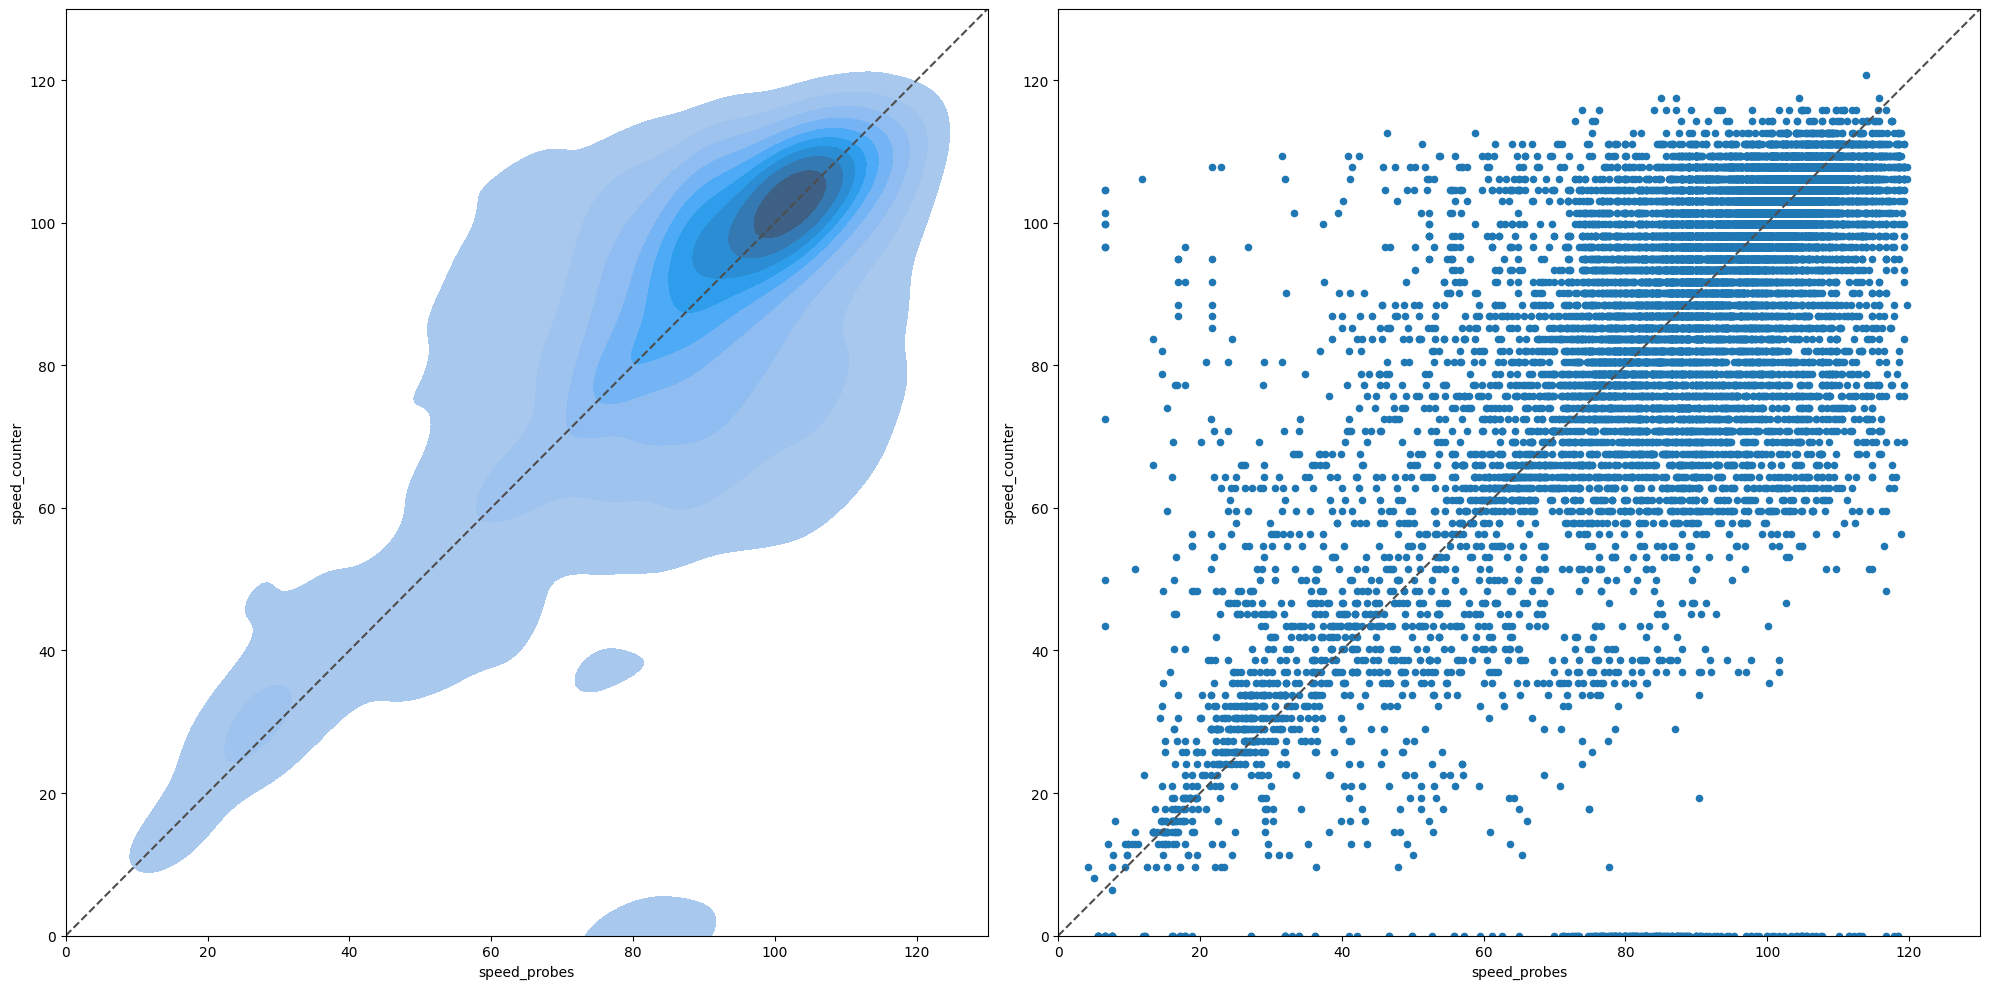

In [85]:
plot_scatters(speeds_merged)

In [88]:
speeds_merged['hour'] = (speeds_merged['t'] / 4).astype(int)
speeds_merged

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day_x,...,osmid,day_y,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph,diff,hour
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,...,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235,6.085321,0
1,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:15,82,102.99776,0,2020-01-29,...,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235,17.350701,0
2,4719,M25/4470A,51.264807,-0.138836,-1,2020-01-29 00:15,88,88.51370,0,2020-01-29,...,2714200,2020-01-29,5,19.0,85.647059,81.081232,27.727779,110.588235,2.866641,0
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,...,2714200,2020-01-29,5,13.0,89.882353,71.905882,37.783166,110.588235,6.678047,0
4,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:30,74,99.77908,1,2020-01-29,...,2714200,2020-01-29,5,13.0,89.882353,71.905882,37.783166,110.588235,9.896727,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19783,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 21:45,408,106.21644,86,2020-01-29,...,4546652,2020-01-29,5,8.0,114.941176,114.941176,0.823529,111.058824,8.724736,21
19784,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:00,338,106.21644,87,2020-01-29,...,4546652,2020-01-29,5,16.0,110.196078,109.712418,5.526753,111.058824,3.979638,21
19785,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:15,347,107.82578,88,2020-01-29,...,4546652,2020-01-29,5,7.0,98.823529,101.552941,5.962930,111.058824,9.002251,22
19786,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:30,310,107.82578,89,2020-01-29,...,4546652,2020-01-29,5,6.0,117.176471,112.862745,10.214463,111.058824,9.350691,22


In [89]:
speeds_merged = speeds_merged.merge(
    edges_df[['u', 'v', 'osmid', 'highway']], left_on=['u', 'v', 'way'], right_on=['u', 'v', 'osmid'])
speeds_merged

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day_x,...,volume_class,volume_y,speed_probes,mean_speed_kph,std_speed_kph,free_flow_kph,diff,hour,osmid_y,highway
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:15,83,91.73238,0,2020-01-29,...,5,19.0,85.647059,81.081232,27.727779,110.588235,6.085321,0,2714200,motorway
1,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:15,82,102.99776,0,2020-01-29,...,5,19.0,85.647059,81.081232,27.727779,110.588235,17.350701,0,2714200,motorway
2,4719,M25/4470A,51.264807,-0.138836,-1,2020-01-29 00:15,88,88.51370,0,2020-01-29,...,5,19.0,85.647059,81.081232,27.727779,110.588235,2.866641,0,2714200,motorway
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-29 00:30,73,96.56040,1,2020-01-29,...,5,13.0,89.882353,71.905882,37.783166,110.588235,6.678047,0,2714200,motorway
4,1476,M25/4459A,51.263198,-0.123678,-1,2020-01-29 00:30,74,99.77908,1,2020-01-29,...,5,13.0,89.882353,71.905882,37.783166,110.588235,9.896727,0,2714200,motorway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19783,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 21:45,408,106.21644,86,2020-01-29,...,5,8.0,114.941176,114.941176,0.823529,111.058824,8.724736,21,4546652,motorway
19784,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:00,338,106.21644,87,2020-01-29,...,5,16.0,110.196078,109.712418,5.526753,111.058824,3.979638,21,4546652,motorway
19785,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:15,347,107.82578,88,2020-01-29,...,5,7.0,98.823529,101.552941,5.962930,111.058824,9.002251,22,4546652,motorway
19786,10566,M25/5554B,51.688038,0.066105,-1,2020-01-29 22:30,310,107.82578,89,2020-01-29,...,5,6.0,117.176471,112.862745,10.214463,111.058824,9.350691,22,4546652,motorway


In [90]:
speeds_merged_hourly = speeds_merged.groupby(['id', 'u', 'v', 'gkey', 'hour', 'highway']).mean()
speeds_merged_hourly = speeds_merged_hourly[['speed_counter', 'speed_probes']].reset_index()
speeds_merged_hourly

/var/folders/dr/jy4_0c5d3q37snprz6rhwwt40000gn/T/ipykernel_57243/495125651.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  speeds_merged_hourly = speeds_merged.groupby(['id', 'u', 'v', 'gkey', 'hour', 'highway']).mean()


,id,u,v,gkey,hour,highway,speed_counter,speed_probes
0,10054,104439,1199441658,104439_1199441658_22633662,0,motorway,102.461313,102.666667
1,10054,104439,1199441658,104439_1199441658_22633662,1,motorway,101.388420,115.764706
2,10054,104439,1199441658,104439_1199441658_22633662,2,motorway,99.779080,91.764706
3,10054,104439,1199441658,104439_1199441658_22633662,3,motorway,101.388420,94.823529
4,10054,104439,1199441658,104439_1199441658_22633662,4,motorway,102.997760,97.411765
...,...,...,...,...,...,...,...,...
5256,9989,208384,257908708,208384_257908708_23800584,19,motorway,100.986085,103.843137
5257,9989,208384,257908708,208384_257908708_23800584,20,motorway,100.986085,96.558824
5258,9989,208384,257908708,208384_257908708_23800584,21,motorway,102.193090,99.764706
5259,9989,208384,257908708,208384_257908708_23800584,22,motorway,102.193090,94.764706


In [19]:
# speeds_merged_onemonth = counter_speeds_onemonth.merge(speed_hour_df_onemonth, on=['u', 'v', 'day', 'h'])
speeds_merged_onemonth = counter_speeds_onemonth.merge(speed_df_onemonth, on=['u', 'v', 'day', 'h'])
speeds_merged_onemonth = speeds_merged_onemonth[speeds_merged_onemonth['volume_y'] > 0]
speeds_merged_onemonth['diff'] = (speeds_merged_onemonth['speed_counter'] - speeds_merged_onemonth['speed_probes']).abs()
speeds_merged_onemonth

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day,way,u,v,h,gkey,osmid,volume_y,speed_probes,diff
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,2714200,12079091,202953,0,12079091_202953_2714200,2714200,2.0,90.352941,7.816799
1,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,2714200,12079091,202953,0,12079091_202953_2714200,2714200,3.0,92.705882,5.463858
2,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,2714200,12079091,202953,0,12079091_202953_2714200,2714200,10.0,110.588235,12.418495
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:30,52,101.38842,1,2020-01-01,2714200,12079091,202953,0,12079091_202953_2714200,2714200,2.0,90.352941,11.035479
4,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:30,52,101.38842,1,2020-01-01,2714200,12079091,202953,0,12079091_202953_2714200,2714200,3.0,92.705882,8.682538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289637,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:45,193,104.60710,94,2020-01-31,4546652,27461215,197771,23,27461215_197771_4546652,4546652,6.0,104.000000,0.607100
1289638,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,4546652,27461215,197771,23,27461215_197771_4546652,4546652,4.0,101.647059,2.960041
1289639,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,4546652,27461215,197771,23,27461215_197771_4546652,4546652,1.0,104.941176,0.334076
1289640,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,4546652,27461215,197771,23,27461215_197771_4546652,4546652,3.0,89.882353,14.724747


In [21]:
speeds_merged_onemonth = speeds_merged_onemonth.merge(
    edges_df[['u', 'v', 'osmid', 'highway']], left_on=['u', 'v', 'way'], right_on=['u', 'v', 'osmid'])
speeds_merged_onemonth

,id,name,lat,lon,heading,time_bin,volume_x,speed_counter,t,day,...,u,v,h,gkey,osmid_x,volume_y,speed_probes,diff,osmid_y,highway
0,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,2.0,90.352941,7.816799,2714200,motorway
1,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,3.0,92.705882,5.463858,2714200,motorway
2,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:15,36,98.16974,0,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,10.0,110.588235,12.418495,2714200,motorway
3,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:30,52,101.38842,1,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,2.0,90.352941,11.035479,2714200,motorway
4,46,M25/4465A,51.264317,-0.132305,-1,2020-01-01 00:30,52,101.38842,1,2020-01-01,...,12079091,202953,0,12079091_202953_2714200,2714200,3.0,92.705882,8.682538,2714200,motorway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289637,10566,M25/5554B,51.688038,0.066105,-1,2020-01-31 23:45,193,104.60710,94,2020-01-31,...,27461215,197771,23,27461215_197771_4546652,4546652,6.0,104.000000,0.607100,4546652,motorway
1289638,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,...,27461215,197771,23,27461215_197771_4546652,4546652,4.0,101.647059,2.960041,4546652,motorway
1289639,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,...,27461215,197771,23,27461215_197771_4546652,4546652,1.0,104.941176,0.334076,4546652,motorway
1289640,10566,M25/5554B,51.688038,0.066105,-1,2020-02-01 00:00,152,104.60710,95,2020-01-31,...,27461215,197771,23,27461215_197771_4546652,4546652,3.0,89.882353,14.724747,4546652,motorway


In [26]:
speeds_merged_onemonth.to_parquet(COUNTER_PATH / 'london' / 'speeds_merged_london_202001.parquet', compression="snappy")

In [22]:
speeds_merged_hourly_onemonth = speeds_merged_onemonth.groupby(['id', 'u', 'v', 'gkey', 'day', 'h', 'highway']).mean()
speeds_merged_hourly_onemonth = speeds_merged_hourly_onemonth[['speed_counter', 'speed_probes']].reset_index()
speeds_merged_hourly_onemonth = speeds_merged_hourly_onemonth.rename(columns={'h': 'hour', 'day': 'date'})
speeds_merged_hourly_onemonth['day'] = speeds_merged_hourly_onemonth['date'].str.slice(-2).astype(int)
speeds_merged_hourly_onemonth

/var/folders/zg/l5sgc79n5h508n79m815wzdw0000gn/T/ipykernel_86328/1770045625.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  speeds_merged_hourly_onemonth = speeds_merged_onemonth.groupby(['id', 'u', 'v', 'gkey', 'day', 'h', 'highway']).mean()


,id,u,v,gkey,date,hour,highway,speed_counter,speed_probes,day
0,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,0,motorway,105.814105,98.352941,1
1,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,1,motorway,102.193090,98.117647,1
2,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,2,motorway,103.802430,99.352941,1
3,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,4,motorway,104.204765,91.647059,1
4,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,5,motorway,101.790755,94.666667,1
...,...,...,...,...,...,...,...,...,...,...
88786,9989,208384,257908708,208384_257908708_23800584,2020-01-31,19,motorway,98.572075,113.333333,31
88787,9989,208384,257908708,208384_257908708_23800584,2020-01-31,20,motorway,99.779080,98.823529,31
88788,9989,208384,257908708,208384_257908708_23800584,2020-01-31,21,motorway,100.583750,107.294118,31
88789,9989,208384,257908708,208384_257908708_23800584,2020-01-31,22,motorway,101.790755,93.950980,31


In [23]:
UBASEPATH = UBER_BASE / 'uber'
CITY = 'london'
YEAR = 2020
MONTH = 1
START_DAY = 1 #29
END_DAY = 31 #29  # incl.
uspeeds_df = pd.read_parquet(UBASEPATH / f"movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet")
uspeeds_df = uspeeds_df[(uspeeds_df["day"] >= START_DAY) & (uspeeds_df["day"] <= END_DAY)]
uspeeds_df["speed_kph_mean"] = uspeeds_df["speed_mph_mean"] * 1.60934
uspeeds_df = uspeeds_df.rename(
    columns={"osm_start_node_id": "u", "osm_end_node_id": "v", "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [f"{u}_{v}_{osmid}" for u, v, osmid in zip(
    uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["osmid"])]
uspeeds_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,u,v,speed_mph_mean,speed_mph_stddev,speed_kph_mean,gkey
0,2020,1,22,8,2020-01-22T08:00:00.000Z,a2720e14e822d3f1a720d2b30322cd7e1e271f43,357044b95c67d9fd9b3d1bb79186cc7caf8b7731,eb5c82102d283c44346a230cd3028af48f05bde8,4973997,32959414,32959411,17.031,2.760,27.408670,32959414_32959411_4973997
1,2020,1,3,19,2020-01-03T19:00:00.000Z,6f7512340e3274c683e3fb9557182fe63a05be1f,c26332985b1cc70e9eb5db3f4e93b4aeaf17364d,d5468e2372e25240ff90b4106df30d4afee7dbbc,8179128,1343922650,108500,9.937,4.454,15.992012,1343922650_108500_8179128
2,2020,1,7,15,2020-01-07T15:00:00.000Z,6f7512340e3274c683e3fb9557182fe63a05be1f,c26332985b1cc70e9eb5db3f4e93b4aeaf17364d,d5468e2372e25240ff90b4106df30d4afee7dbbc,8179128,1343922650,108500,9.690,1.981,15.594505,1343922650_108500_8179128
3,2020,1,7,13,2020-01-07T13:00:00.000Z,6f7512340e3274c683e3fb9557182fe63a05be1f,c26332985b1cc70e9eb5db3f4e93b4aeaf17364d,d5468e2372e25240ff90b4106df30d4afee7dbbc,8179128,1343922650,108500,7.480,1.780,12.037863,1343922650_108500_8179128
4,2020,1,10,7,2020-01-10T07:00:00.000Z,6f7512340e3274c683e3fb9557182fe63a05be1f,c26332985b1cc70e9eb5db3f4e93b4aeaf17364d,d5468e2372e25240ff90b4106df30d4afee7dbbc,8179128,1343922650,108500,8.219,2.567,13.227165,1343922650_108500_8179128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41490516,2020,1,30,21,2020-01-30T21:00:00.000Z,dbdfa888b03e691f7308eb33c34e2bda89f5aa17,4193084a52c6c05ccc0cf0b6ec375aa5fc60d074,da8e1f84ab98c90129c546f4c2e9a545054102a7,563980454,3863146613,3863127062,15.496,2.162,24.938333,3863146613_3863127062_563980454
41490517,2020,1,31,0,2020-01-31T00:00:00.000Z,dbdfa888b03e691f7308eb33c34e2bda89f5aa17,4193084a52c6c05ccc0cf0b6ec375aa5fc60d074,da8e1f84ab98c90129c546f4c2e9a545054102a7,563980454,3863146613,3863127062,17.755,3.361,28.573832,3863146613_3863127062_563980454
41490518,2020,1,15,13,2020-01-15T13:00:00.000Z,dbdfa888b03e691f7308eb33c34e2bda89f5aa17,4193084a52c6c05ccc0cf0b6ec375aa5fc60d074,da8e1f84ab98c90129c546f4c2e9a545054102a7,563980454,3863146613,3863127062,15.176,3.059,24.423344,3863146613_3863127062_563980454
41490519,2020,1,19,1,2020-01-19T01:00:00.000Z,dbdfa888b03e691f7308eb33c34e2bda89f5aa17,4193084a52c6c05ccc0cf0b6ec375aa5fc60d074,da8e1f84ab98c90129c546f4c2e9a545054102a7,563980454,3863146613,3863127062,18.544,8.699,29.843601,3863146613_3863127062_563980454


In [91]:
usm = speeds_merged_hourly.merge(uspeeds_df, on=['u', 'v', 'gkey', 'hour'])
usm

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_mph_mean,speed_mph_stddev,speed_kph_mean
0,10054,104439,1199441658,104439_1199441658_22633662,1,motorway,101.388420,115.764706,2020,1,29,2020-01-29T01:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,59.439,6.054,95.657560
1,10054,104439,1199441658,104439_1199441658_22633662,2,motorway,99.779080,91.764706,2020,1,29,2020-01-29T02:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,59.987,6.692,96.539479
2,10054,104439,1199441658,104439_1199441658_22633662,3,motorway,101.388420,94.823529,2020,1,29,2020-01-29T03:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,60.402,7.190,97.207355
3,10054,104439,1199441658,104439_1199441658_22633662,4,motorway,102.997760,97.411765,2020,1,29,2020-01-29T04:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,62.740,6.939,100.969992
4,10054,104439,1199441658,104439_1199441658_22633662,5,motorway,102.997760,98.352941,2020,1,29,2020-01-29T05:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,61.633,5.962,99.188452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,9928,200284,104439,200284_104439_22632032,17,motorway_link,74.834310,85.578431,2020,1,29,2020-01-29T17:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,46.705,7.676,75.164225
2946,9928,200284,104439,200284_104439_22632032,19,motorway_link,78.052990,81.382353,2020,1,29,2020-01-29T19:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.442,5.869,77.959648
2947,9928,200284,104439,200284_104439_22632032,21,motorway_link,82.076340,78.823529,2020,1,29,2020-01-29T21:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,52.963,6.228,85.235474
2948,9928,200284,104439,200284_104439_22632032,22,motorway_link,82.478675,94.029412,2020,1,29,2020-01-29T22:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.132,5.650,77.460753


In [92]:
usm['diff'] = (usm['speed_counter'] - usm['speed_kph_mean']).abs()
usm

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_mph_mean,speed_mph_stddev,speed_kph_mean,diff
0,10054,104439,1199441658,104439_1199441658_22633662,1,motorway,101.388420,115.764706,2020,1,29,2020-01-29T01:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,59.439,6.054,95.657560,5.730860
1,10054,104439,1199441658,104439_1199441658_22633662,2,motorway,99.779080,91.764706,2020,1,29,2020-01-29T02:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,59.987,6.692,96.539479,3.239601
2,10054,104439,1199441658,104439_1199441658_22633662,3,motorway,101.388420,94.823529,2020,1,29,2020-01-29T03:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,60.402,7.190,97.207355,4.181065
3,10054,104439,1199441658,104439_1199441658_22633662,4,motorway,102.997760,97.411765,2020,1,29,2020-01-29T04:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,62.740,6.939,100.969992,2.027768
4,10054,104439,1199441658,104439_1199441658_22633662,5,motorway,102.997760,98.352941,2020,1,29,2020-01-29T05:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,61.633,5.962,99.188452,3.809308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,9928,200284,104439,200284_104439_22632032,17,motorway_link,74.834310,85.578431,2020,1,29,2020-01-29T17:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,46.705,7.676,75.164225,0.329915
2946,9928,200284,104439,200284_104439_22632032,19,motorway_link,78.052990,81.382353,2020,1,29,2020-01-29T19:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.442,5.869,77.959648,0.093342
2947,9928,200284,104439,200284_104439_22632032,21,motorway_link,82.076340,78.823529,2020,1,29,2020-01-29T21:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,52.963,6.228,85.235474,3.159134
2948,9928,200284,104439,200284_104439_22632032,22,motorway_link,82.478675,94.029412,2020,1,29,2020-01-29T22:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.132,5.650,77.460753,5.017922


<AxesSubplot: >

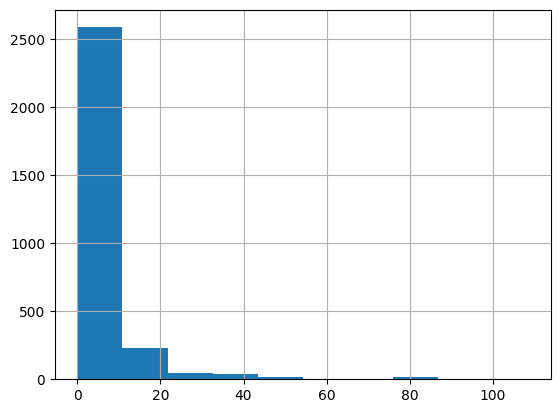

In [93]:
usm['diff'].hist()

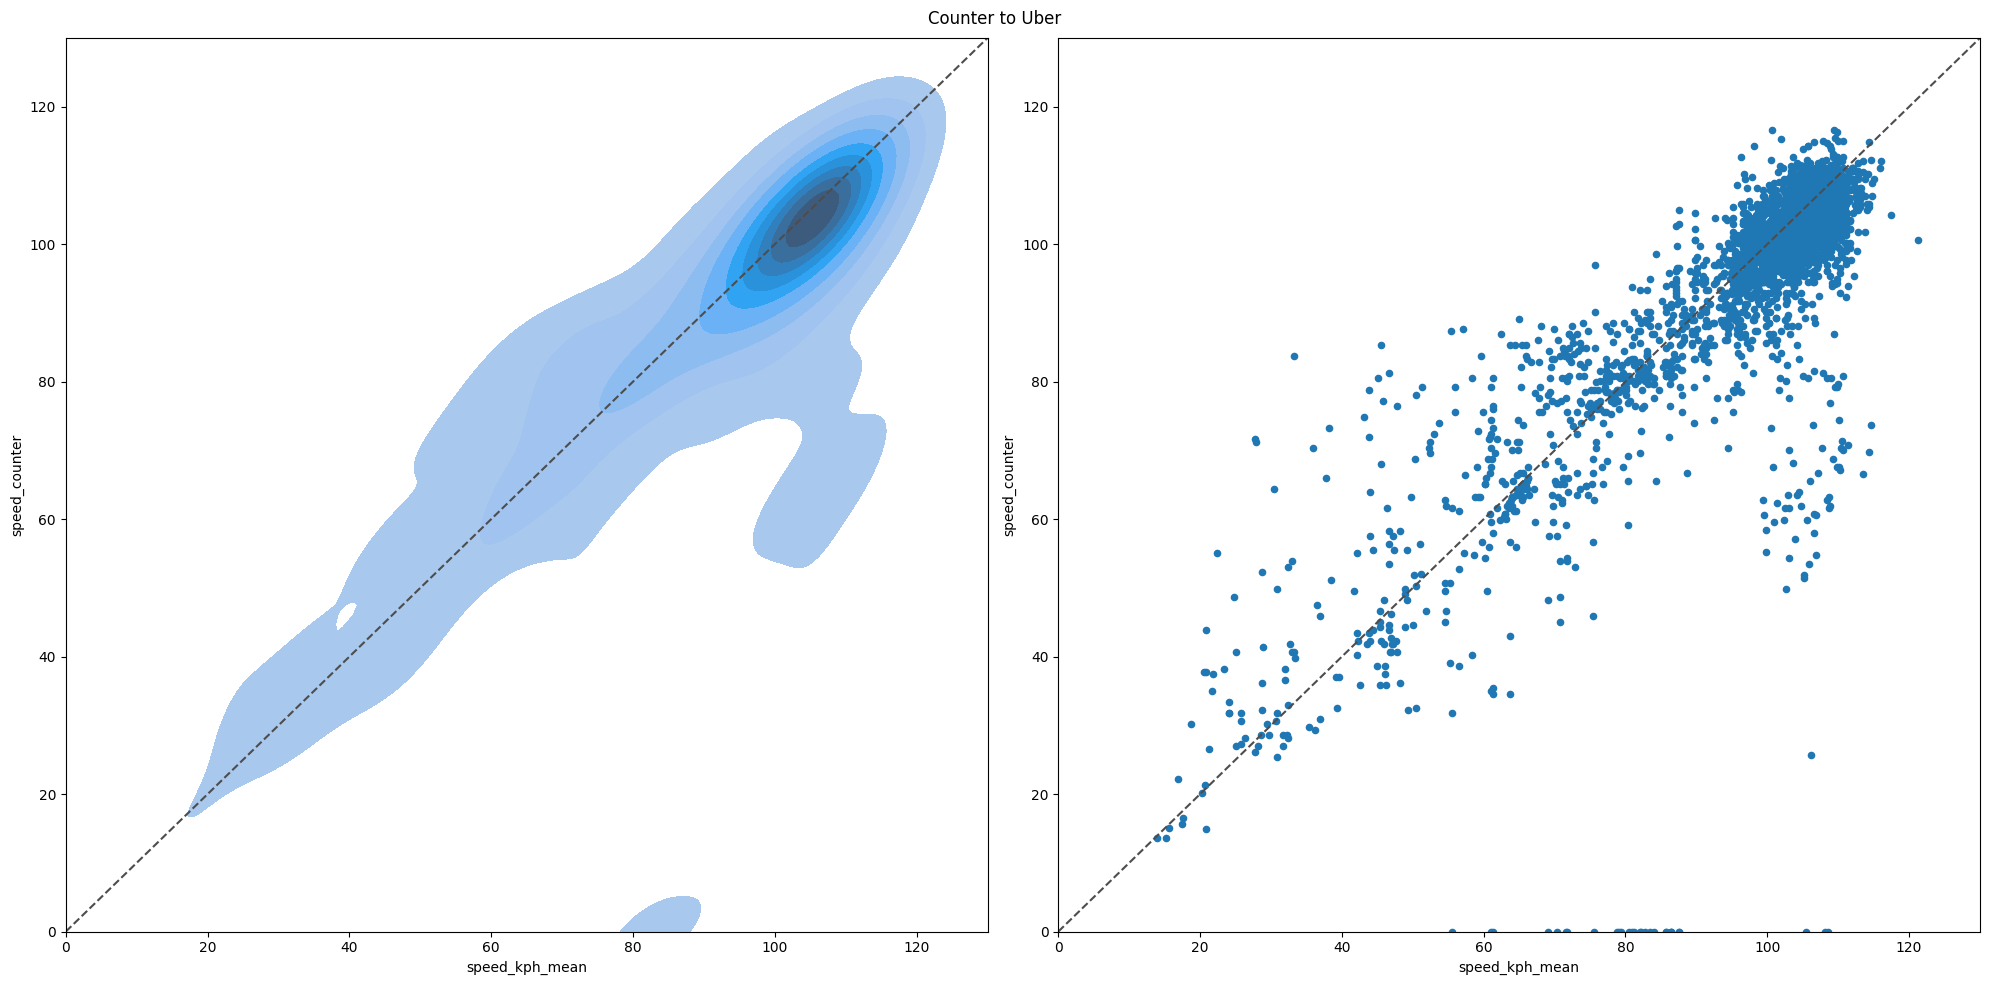

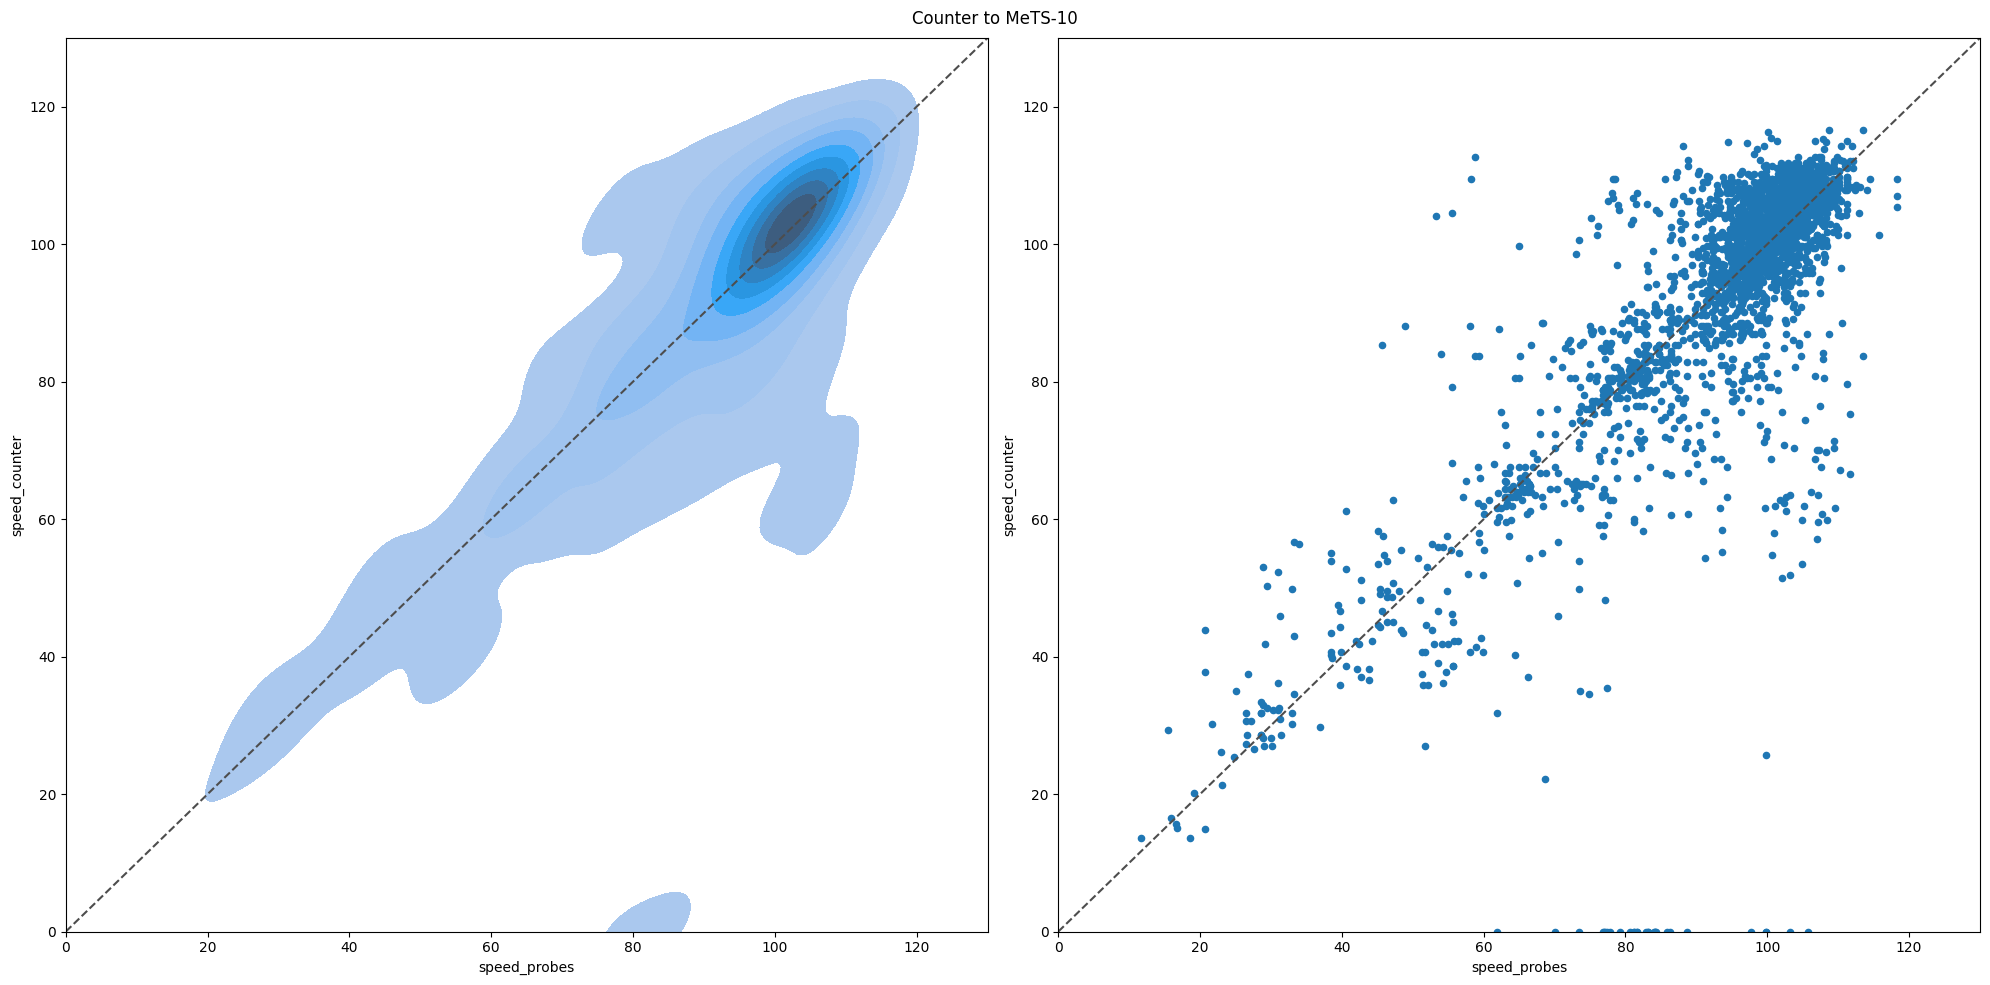

In [94]:
def plot_kde_scatter(df, ax, city=None, labelsize=24, titlesize=36, x_field='speed_probes'):
    ax.plot([0, 130], [0, 130], ls="--", c=".3")
    ax.set_xlim([0,130])
    ax.set_ylim([0,130])
    sns.kdeplot(data=df, x=x_field, y='speed_counter', fill=True, levels=10, ax=ax)
    if city:
        ax.set_xlabel(f'MeTS-10 Speed [km/h]', fontsize=titlesize)
        ax.set_ylabel('Detector Speed [km/h]', fontsize=titlesize)
        ax.tick_params(axis='x', which='major', labelsize=labelsize)
        ax.tick_params(axis='y', which='major', labelsize=labelsize)
        ax.title.set_text(city)
        ax.title.set_size(titlesize)

def plot_scatters(df, t_from=None, t_to=None, title=None, x_field='speed_probes'):
    if t_from and t_to:
        df = df[(df['t'] >= t_from) & (df['t'] < t_to)]
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
    if title:
        fig.suptitle(title)
    ax = axs[0]
    plot_kde_scatter(df, ax, x_field=x_field)
    ax = axs[1]
    ax.plot([0, 130], [0, 130], ls="--", c=".3")
    ax.set_xlim([0,130])
    ax.set_ylim([0,130])
    df.plot(x=x_field, y='speed_counter', kind='scatter', ax=ax)

plot_scatters(usm, title='Counter to Uber', x_field='speed_kph_mean')
plot_scatters(usm, title='Counter to MeTS-10')

In [95]:
usm['id'].unique()

array(['10054', '10111', '10275', '1029', '4259', '4375', '10311',
       '10332', '5008', '10367', '10378', '10522', '10369', '1040',
       '10400', '10441', '10463', '1041', '665', '10501', '10510',
       '10520', '10531', '10566', '1067', '1080', '28', '2954', '4649',
       '841', '1069', '1442', '1995', '2383', '5221', '5288', '1162',
       '1270', '138', '3216', '4000', '4092', '5457', '6156', '885',
       '12260', '12569', '1284', '1593', '2319', '3619', '4641', '4669',
       '5071', '5870', '6269', '13012', '1429', '1476', '46', '4719',
       '1503', '5796', '1513', '2449', '5878', '6255', '1578', '4859',
       '1639', '2919', '5526', '818', '905', '1737', '1752', '1754',
       '1841', '4044', '542', '1867', '1870', '1884', '1886', '1959',
       '4397', '4597', '5186', '1990', '2005', '699', '2014', '2097',
       '3437', '4145', '547', '5875', '2144', '4176', '2194', '2246',
       '9989', '2278', '2339', '2370', '3203', '591', '2419', '4223',
       '2714', '3058', '

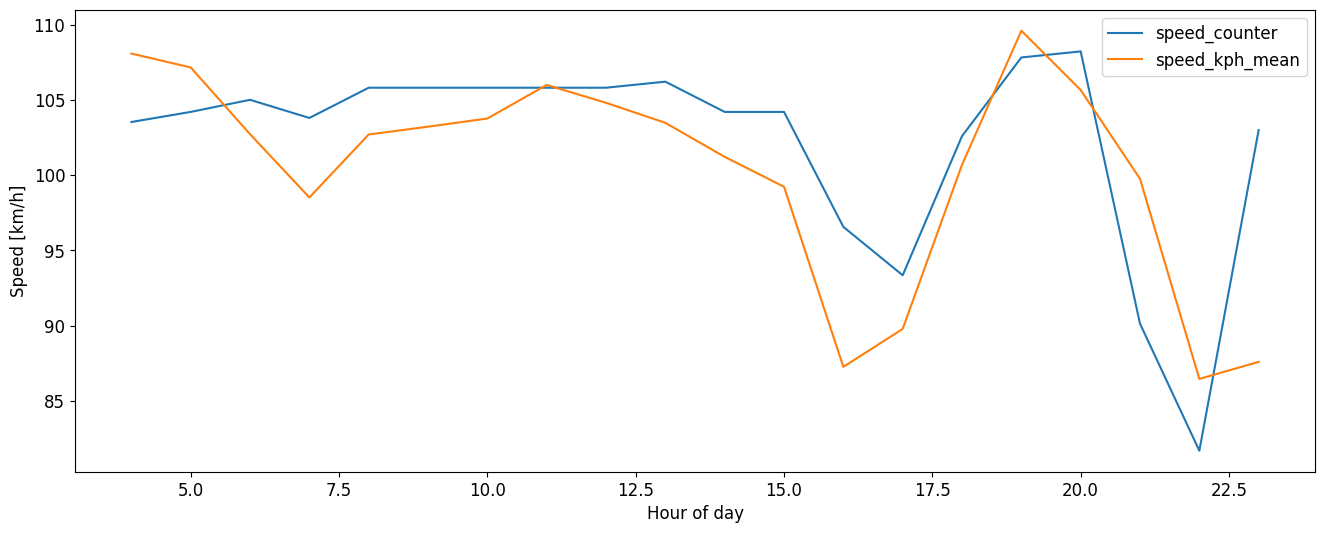

In [70]:
def plot_speed_dayline(df, id, x_field="t", plot_volume=False, figsize=(16,6), labels={}, labelsize=12, ax=None):
    cols = ["speed_counter", "speed_kph_mean"]
    label_names = ["speed_counter", "speed_kph_mean"]
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    df[df['id'] == id].plot(x=x_field, y=cols, label=label_names, fontsize=labelsize, ax=ax)
    ax.set_ylabel('Speed [km/h]', fontsize=labelsize)
    ax.set_xlabel('Hour of day', fontsize=labelsize)
    plt.legend(fontsize=labelsize)

plot_speed_dayline(usm, '28', x_field="hour")
plot_counter(counters_assigned_df, edges_df, '28')

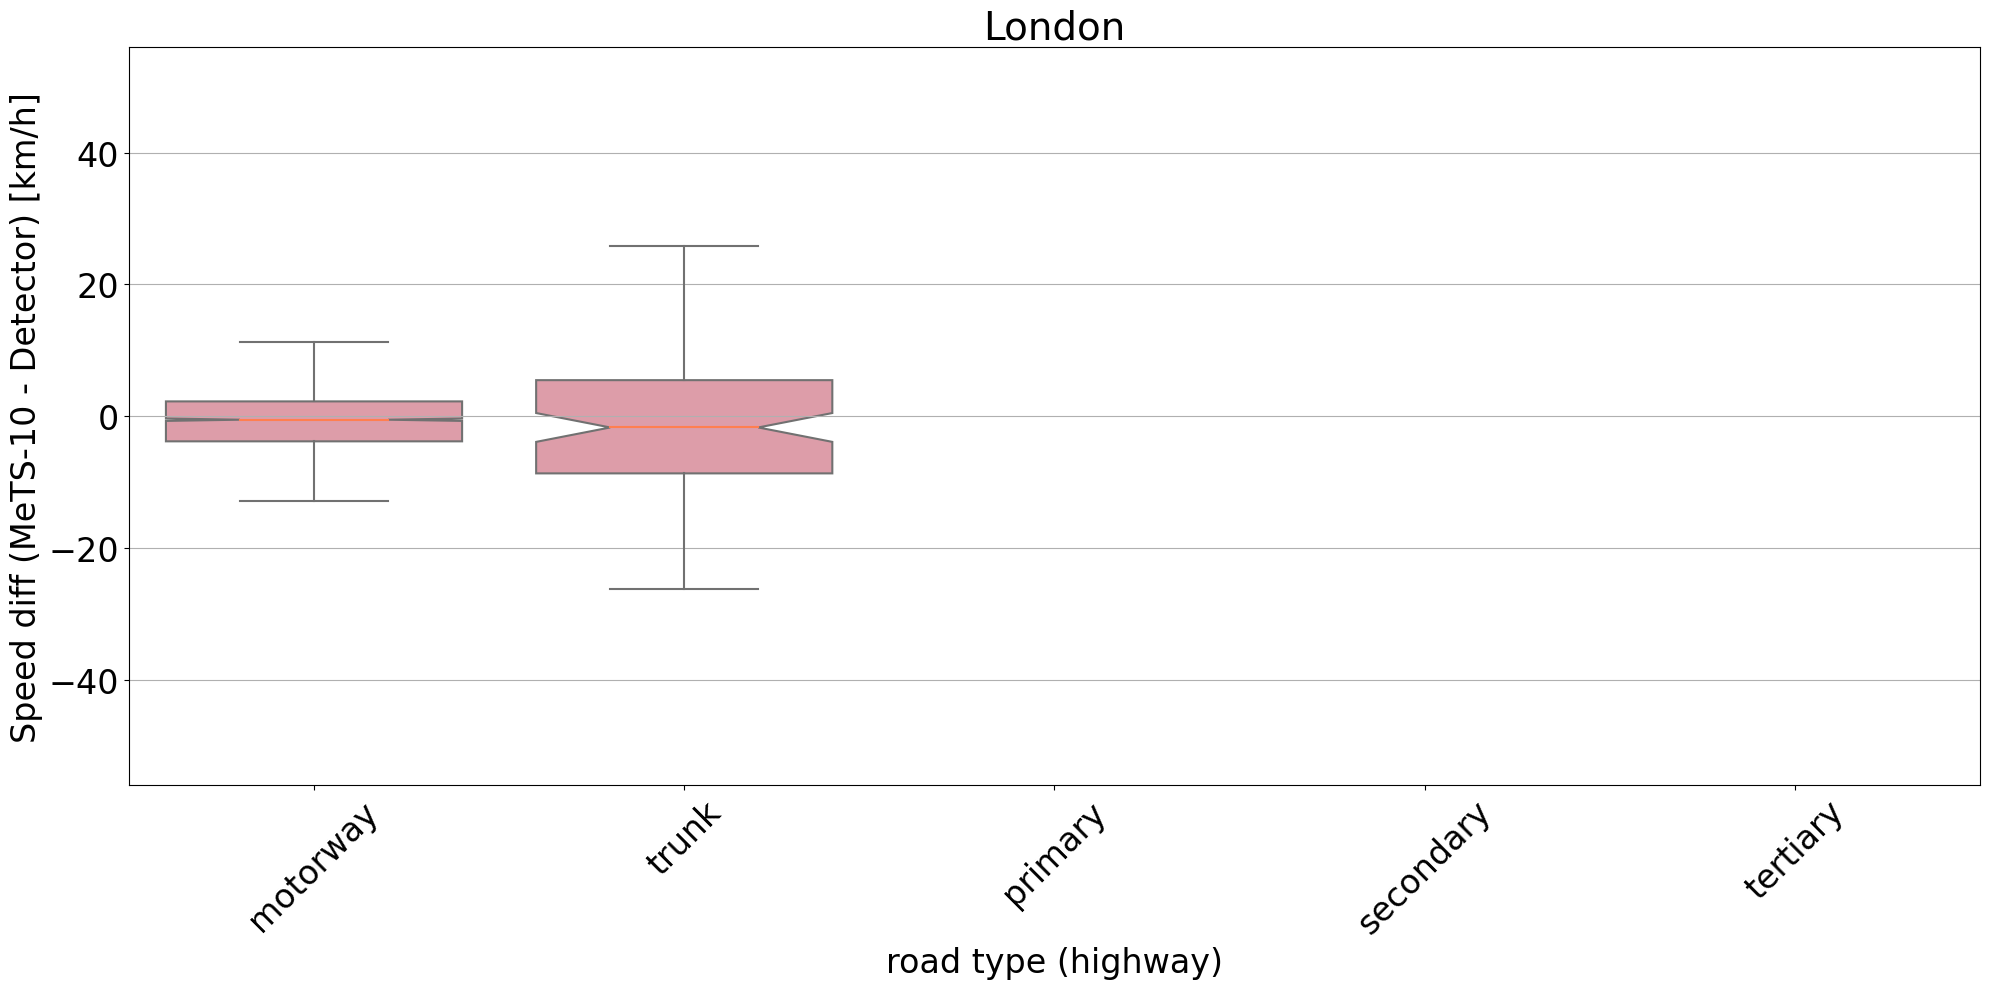

In [98]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

highway_ordering = [
    'motorway', 'motorway_link', 
    'trunk','trunk_link', 
    'primary','primary_link',
    'secondary', 'secondary_link', 
    'tertiary','tertiary_link',
    'unclassified',  'residential',
    'living_street', 'service',
    'cycleway', 'road', 'construction'
]
        
def diff_boxplot(data, ax=None, labelsize=24, city=''):
    data = data[~data['highway'].str.contains('_link')].copy()
    data.loc[data["highway"].str.contains('motorway'), "highway"] = "motorway"
    data.loc[data["highway"].str.contains('trunk'), "highway"] = "trunk"
    data.loc[data["highway"].str.contains('primary'), "highway"] = "primary"
    data["sort_key"] = [highway_ordering.index(hw) for hw in data["highway"]]
    data = data.sort_values("sort_key")
    data["diff_km"] = data['speed_probes'] - data['speed_counter']
    if not ax:
        fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
    sns.boxplot(data=data, 
                x="highway",
                y="diff_km",  
                notch=True, 
                sym='',
                order=['motorway', 'trunk', 'primary', 'secondary', 'tertiary'],
                palette=osm_color_palette(),
                medianprops={"color": "coral"},
                ax=ax)
    ax.set(ylim=(-56, 56))
    ax.set_xlabel('road type (highway)', fontsize=labelsize)
    ax.set_ylabel('Speed diff (MeTS-10 - Detector) [km/h]', fontsize=labelsize)
    ax.tick_params(axis='x', which='major', labelsize=labelsize, rotation=45)
    ax.tick_params(axis='y', which='major', labelsize=labelsize)
    ax.grid(axis='y')
    ax.title.set_text(city)
    ax.title.set_size(labelsize+4)


diff_boxplot(usm, city='London')
# plt.savefig("london_counter_uber_diff.png")

In [99]:
usm.to_parquet(COUNTER_PATH / 'london' / 'speeds_merged_uber_london.parquet', compression="snappy")

In [24]:
usm_onemonth = speeds_merged_hourly_onemonth.merge(uspeeds_df, on=['u', 'v', 'gkey', 'day', 'hour'])
usm_onemonth['diff'] = (usm_onemonth['speed_counter'] - usm_onemonth['speed_kph_mean']).abs()
usm_onemonth

,id,u,v,gkey,date,hour,highway,speed_counter,speed_probes,day,...,month,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_mph_mean,speed_mph_stddev,speed_kph_mean,diff
0,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,0,motorway,105.814105,98.352941,1,...,1,2020-01-01T00:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,64.122,6.953,103.194099,2.620006
1,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,1,motorway,102.193090,98.117647,1,...,1,2020-01-01T01:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,60.117,7.525,96.748693,5.444397
2,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,2,motorway,103.802430,99.352941,1,...,1,2020-01-01T02:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,61.874,7.611,99.576303,4.226127
3,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,4,motorway,104.204765,91.647059,1,...,1,2020-01-01T04:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,62.691,6.874,100.891134,3.313631
4,10054,104439,1199441658,104439_1199441658_22633662,2020-01-01,5,motorway,101.790755,94.666667,1,...,1,2020-01-01T05:00:00.000Z,a1e5515712ba2208ce69fbc2aaa73d5b9917903e,ba467e2d4a1fe987a7143f10a90ec936c09511d6,3e29022801b79c483e07086679201fc2793e00b9,22633662,61.744,7.629,99.367089,2.423666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56220,9928,200284,104439,200284_104439_22632032,2020-01-31,17,motorway_link,76.041315,69.823529,31,...,1,2020-01-31T17:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,44.548,3.979,71.692878,4.348437
56221,9928,200284,104439,200284_104439_22632032,2020-01-31,18,motorway_link,76.845985,91.852941,31,...,1,2020-01-31T18:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,45.414,3.301,73.086567,3.759418
56222,9928,200284,104439,200284_104439_22632032,2020-01-31,19,motorway_link,78.455325,84.264706,31,...,1,2020-01-31T19:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,46.374,2.491,74.631533,3.823792
56223,9928,200284,104439,200284_104439_22632032,2020-01-31,21,motorway_link,81.674005,103.686275,31,...,1,2020-01-31T21:00:00.000Z,13e4de89f3887b57da95d5e442be2f1d0ce0c435,f9b5c209f7e465097c92b0cddec30f4b467434f5,ba467e2d4a1fe987a7143f10a90ec936c09511d6,22632032,48.220,8.237,77.602375,4.071630


In [25]:
usm_onemonth.to_parquet(COUNTER_PATH / 'london' / 'speeds_merged_uber_london_202001.parquet', compression="snappy")